In [25]:
import os
from pathlib import Path
from typing import List, Tuple, Optional, Any
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import trange, tqdm
from models import revinTransformer
# Notebook-wide defaults
pd.options.mode.chained_assignment = 'warn'
torch.set_num_threads(1)


In [26]:
class TimeSeriesDatasetWithMemory(Dataset):
    def __init__(self, X:List[torch.Tensor], Y:List[torch.Tensor]):
        """
        Args:
            X (torch.Tensor): Input data of shape (num_samples, seq_len, input_dim).
            Y (torch.Tensor): Target data of shape (num_samples, seq_len, output_dim).
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        # Return the number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # Return a single sample (X[idx], Y[idx])
        return self.X[idx], self.Y[idx]

In [27]:

def load_segments_from_files(
    infant_file_path: Path,
    adult_file_path: Path,
    min_length: int = 125,
) -> List[pd.DataFrame]:
    meaningfull_columns = ["Frame", "success", "AU06_r", "AU12_r"]
    adult_file = pd.read_csv(adult_file_path)[meaningfull_columns]
    infant_file = pd.read_csv(infant_file_path)[meaningfull_columns]

    merged_file = pd.merge(
        infant_file,
        adult_file,
        on="Frame",
        how="inner",
        suffixes=("_infant", "_adult"),
    )

    continous_dfs: List[pd.DataFrame] = []
    output_columns = [
        "Frame",
        "AU06_r_infant",
        "AU12_r_infant",
        "AU06_r_adult",
        "AU12_r_adult",
    ]
    current_segment = pd.DataFrame(columns=output_columns)
    for row in merged_file.itertuples():
        if row.success_infant >= 0.75 and row.success_adult >= 0.75:
            current_segment.loc[len(current_segment)] = (
                row.Frame,
                row.AU06_r_infant,
                row.AU12_r_infant,
                row.AU06_r_adult,
                row.AU12_r_adult,
            )
        else:
            if len(current_segment) > min_length:
                continous_dfs.append(current_segment)
            current_segment = pd.DataFrame(columns=output_columns)
    if len(current_segment) > min_length:
        continous_dfs.append(current_segment)
    return continous_dfs



In [28]:

def segments_from_one_video_to_dataset(
    segments: List[pd.DataFrame],
    input_length: int,
    output_length: int,
    train_test_split: float = 0.8,
    stride: int = 10,
    with_long_memory: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    X = []
    Y = []
    for segment in segments:
        data = segment[
            ["AU06_r_infant", "AU12_r_infant", "AU06_r_adult", "AU12_r_adult"]
        ].to_numpy()
        num_samples = len(data) - input_length - output_length + 1
        for i in range(0,num_samples,stride):
            if with_long_memory:
                X.append(data[ : i + input_length])
            else:
                X.append(data[i : i + input_length])
            Y.append(data[i + input_length : i + input_length + output_length])
    if not with_long_memory:
        numpy_X = np.array(X, dtype=np.float32)
        numpy_Y = np.array(Y, dtype=np.float32)
        split_idx = int(len(X) * train_test_split)
        train_X = torch.from_numpy(numpy_X[:split_idx])
        train_Y = torch.from_numpy(numpy_Y[:split_idx])
        test_X = torch.from_numpy(numpy_X[split_idx:])
        test_Y = torch.from_numpy(numpy_Y[split_idx:])
    else:
        split_idx = int(len(X) * train_test_split)
        train_X = [torch.from_numpy(x.astype(np.float32)) for x in X[:split_idx]]
        train_Y = [torch.from_numpy(y.astype(np.float32)) for y in Y[:split_idx]]
        test_X = [torch.from_numpy(x.astype(np.float32)) for x in X[split_idx:]]
        test_Y = [torch.from_numpy(y.astype(np.float32)) for y in Y[split_idx:]]
    return train_X, train_Y, test_X, test_Y

In [29]:



def load_multiple_files(
    month: int,
    root: Path,
    input_length: int,
    output_length: int,
    with_long_memory: bool = False,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    subdirs = [p for p in root.iterdir() if p.is_dir()]
    train_X_list: List[torch.Tensor] = []
    train_Y_list: List[torch.Tensor] = []
    test_X_list: List[torch.Tensor] = []
    test_Y_list: List[torch.Tensor] = []
    for subdir in subdirs:
        if subdir.match(f"**/diti_*_{month}"):
            infant_path = subdir / "Kamera 1" / "infant.csv"
            adult_path = subdir / "Kamera 2" / "adult.csv"
            if not infant_path.exists() or not adult_path.exists():
                continue
            segments = load_segments_from_files(infant_path, adult_path)
            if not segments:
                continue
            tX, tY, eX, eY = segments_from_one_video_to_dataset(
                segments, input_length=input_length, output_length=output_length, with_long_memory=with_long_memory
            )
            if len(tX) == 0:
                continue
            train_X_list.append(tX)
            train_Y_list.append(tY)
            test_X_list.append(eX)
            test_Y_list.append(eY)
    train_X = sum(train_X_list, []) if with_long_memory else torch.cat(train_X_list, dim=0)
    train_Y = sum(train_Y_list, []) if with_long_memory else torch.cat(train_Y_list, dim=0)
    test_X = sum(test_X_list, []) if with_long_memory else torch.cat(test_X_list, dim=0)
    test_Y = sum(test_Y_list, []) if with_long_memory else torch.cat(test_Y_list, dim=0)
    return train_X, train_Y, test_X, test_Y

In [30]:
train_X, train_Y, test_X, test_Y = load_multiple_files(1, Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=50, output_length=50, with_long_memory=True)

KeyboardInterrupt: 

In [ ]:
from models import revinTransformer

batch_size = 32
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(TimeSeriesDatasetWithMemory(train_X, train_Y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TimeSeriesDatasetWithMemory(test_X, test_Y), batch_size=batch_size, shuffle=False)

model = revinTransformer.RevinTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [ ]:
def sample_mask_flags() -> Tuple[bool, bool]:
    r = torch.rand(1).item()
    if r < 0.1:
        return True, False  # mask mom only
    if r < 0.2:
        return False, True  # mask child only
    return False, False


def masked_mse_loss(
    pred: torch.Tensor,
    target: torch.Tensor,
    *,
    mask_child: bool,
    mask_mom: bool,
    child_dim: int = 2,
) -> torch.Tensor:
    """Compute MSE while ignoring channels of the masked person.

    Assumes last dimension is feature/channel dim, with:
    - child in [:child_dim]
    - mom   in [child_dim:]

    The model still predicts full `pred`; we only change what contributes to loss.
    """
    per_elem = (pred - target).pow(2)  # same shape as pred/target

    if mask_child and mask_mom:
        return per_elem.new_tensor(0.0)
    if mask_child:
        per_elem = per_elem[..., child_dim:]
    elif mask_mom:
        per_elem = per_elem[..., :child_dim]

    return per_elem.mean()

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_pad(batch, pad_value: float = 0.0):
    """Pad variable-length sequences and return padding masks and lengths.

    Returns: Xp, Yp, lengths_x, lengths_y, src_key_padding_mask, tgt_key_padding_mask
    src/tgt_key_padding_mask have shape (B, L) with True for PAD positions.
    """
    Xs, Ys = zip(*batch)
    Xs = [torch.as_tensor(x, dtype=torch.float32) for x in Xs]
    Ys = [torch.as_tensor(y, dtype=torch.float32) for y in Ys]
    lengths_x = torch.tensor([x.shape[0] for x in Xs], dtype=torch.long)
    lengths_y = torch.tensor([y.shape[0] for y in Ys], dtype=torch.long)
    Xp = pad_sequence(Xs, batch_first=True, padding_value=pad_value)
    Yp = pad_sequence(Ys, batch_first=True, padding_value=pad_value)
    src_key_padding_mask = torch.arange(Xp.size(1))[None, :] >= lengths_x[:, None]
    tgt_key_padding_mask = torch.arange(Yp.size(1))[None, :] >= lengths_y[:, None]
    return Xp, Yp, lengths_x, lengths_y, src_key_padding_mask, tgt_key_padding_mask

# Example: build DataLoaders with the collate function
batch_size = 32
train_loader = DataLoader(TimeSeriesDatasetWithMemory(train_X, train_Y), batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
test_loader = DataLoader(TimeSeriesDatasetWithMemory(test_X, test_Y), batch_size=batch_size, shuffle=False, collate_fn=collate_pad)

# Quick sanity check (peek shapes)
batch = next(iter(train_loader))
Xp, Yp, len_x, len_y, src_mask, tgt_mask = batch
print('Xp', Xp.shape, 'Yp', Yp.shape, 'len_x', len_x.shape, 'src_mask', src_mask.shape)

Xp torch.Size([32, 1850, 4]) Yp torch.Size([32, 50, 4]) len_x torch.Size([32]) src_mask torch.Size([32, 1850])


In [ ]:
from tqdm.auto import trange, tqdm
epochs = 5
patience = 8
best_val = float('inf')
no_improve = 0
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
for epoch in trange(epochs, desc='epochs'):
    model.train()
    total_loss = 0.0
    for Xp, Yp, len_x, len_y, src_mask, tgt_mask in tqdm(train_loader, desc=f'epoch {epoch}', leave=False):
        Xp = Xp.to(device)
        Yp = Yp.to(device)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        child_src = Xp[..., :2]
        mom_src = Xp[..., 2:]
        tgt_in = torch.zeros_like(Yp)
        tgt_in[:, 1:, :] = Yp[:, :-1, :]
        child_tgt_in = tgt_in[..., :2]
        mom_tgt_in = tgt_in[..., 2:]
        mask_mom, mask_child = sample_mask_flags()
        optimizer.zero_grad()
        pred = model(
            child_src,
            mom_src,
            child_tgt_in,
            mom_tgt_in,
            mask_child=mask_child,
            mask_mom=mask_mom,
            src_key_padding_mask=src_mask,
            tgt_key_padding_mask=tgt_mask,
        )
        loss = masked_mse_loss(pred, Yp, mask_child=mask_child, mask_mom=mask_mom)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xp.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_src, val_tgt, val_len_x, val_len_y, val_src_pad_mask, val_tgt_pad_mask in tqdm(test_loader, desc=f'val epoch {epoch}', leave=False):
            val_src = val_src.to(device)
            val_tgt = val_tgt.to(device)
            val_src_pad_mask = val_src_pad_mask.to(device)
            val_tgt_pad_mask = val_tgt_pad_mask.to(device)
            val_child_src = val_src[..., :2]
            val_mom_src = val_src[..., 2:]
            val_tgt_in = torch.zeros_like(val_tgt)
            val_tgt_in[:, 1:, :] = val_tgt[:, :-1, :]
            val_child_tgt_in = val_tgt_in[..., :2]
            val_mom_tgt_in = val_tgt_in[..., 2:]
            val_pred = model(
                val_child_src,
                val_mom_src,
                val_child_tgt_in,
                val_mom_tgt_in,
                mask_child=False,
                mask_mom=False,
                src_key_padding_mask=val_src_pad_mask,
                tgt_key_padding_mask=val_tgt_pad_mask,
            )
            val_loss += masked_mse_loss(val_pred, val_tgt, mask_child=False, mask_mom=False).item() * val_src.size(0)
    val_loss = val_loss / len(test_loader.dataset)
    print(f"end=epoch {epoch}: train_loss={avg_loss:.6f}, val_loss={val_loss:.6f}")
    # Scheduler step and early stopping check
    scheduler.step()
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        no_improve = 0
        best_path = Path("./revin_transformer_model_best.pth")
        torch.save({"model_state_dict": model.state_dict()}, best_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

# final save
save_path = Path("./revin_transformer_model.pth")
save_path.parent.mkdir(parents=True, exist_ok=True)
torch.save({"model_state_dict": model.state_dict()}, save_path)



epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 0:   0%|          | 0/296 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import torch
import random

# pick a random sample from the test dataset
idx = random.randrange(len(test_loader.dataset))
sample_X, sample_Y = test_loader.dataset[idx]

# collate single sample into a batch (uses existing collate_pad)
Xp, Yp, len_x, len_y, src_mask, tgt_mask = collate_pad([(sample_X, sample_Y)])
Xp = Xp.to(device)
Yp = Yp.to(device)
src_mask = src_mask.to(device)
tgt_mask = tgt_mask.to(device)

# prepare inputs for model (same as training/validation)
child_src = Xp[..., :2]
mom_src = Xp[..., 2:]
tgt_in = torch.zeros_like(Yp)
tgt_in[:, 1:, :] = Yp[:, :-1, :]
child_tgt_in = tgt_in[..., :2]
mom_tgt_in = tgt_in[..., 2:]

# eval
model.eval()
with torch.no_grad():
    pred = model(
        child_src,
        mom_src,
        child_tgt_in,
        mom_tgt_in,
        mask_child=False,
        mask_mom=False,
        src_key_padding_mask=src_mask,
        tgt_key_padding_mask=tgt_mask,
    )
    loss = masked_mse_loss(pred, Yp, mask_child=False, mask_mom=False).item()

print(f"sample_idx={idx}, loss={loss:.6f}")
print("pred.shape", pred.shape, "target.shape", Yp.shape)
# print first timestep of prediction vs target for inspection
print("pred[0, :5]\n", pred[0, :5].cpu().numpy())
print("target[0, :5]\n", Yp[0, :5].cpu().numpy())

sample_idx=125, loss=3.391298
pred.shape torch.Size([1, 50, 4]) target.shape torch.Size([1, 50, 4])
pred[0, :5]
 [[1.6435097e-01 6.0471595e-04 6.1850381e-01 1.4149806e+00]
 [1.4675894e-01 3.8902854e-04 8.2737470e-01 1.8614691e+00]
 [1.3912401e-01 1.2448921e-03 9.3855315e-01 2.2976017e+00]
 [1.4048794e-01 2.6493161e-03 9.8305345e-01 2.5744143e+00]
 [1.4258377e-01 3.2647531e-03 9.8710746e-01 2.6567080e+00]]
target[0, :5]
 [[0.4  0.   0.4  0.26]
 [0.44 0.   0.42 0.15]
 [0.48 0.   0.35 0.12]
 [0.61 0.   0.28 0.09]
 [0.61 0.   0.22 0.13]]


Loaded model from /net/tscratch/people/plgfimpro/korelacje/models_with_revin/masked_m1_in100_out50_lr1e-3-2.pt


val epoch 0:   0%|          | 0/75 [00:00<?, ?it/s]

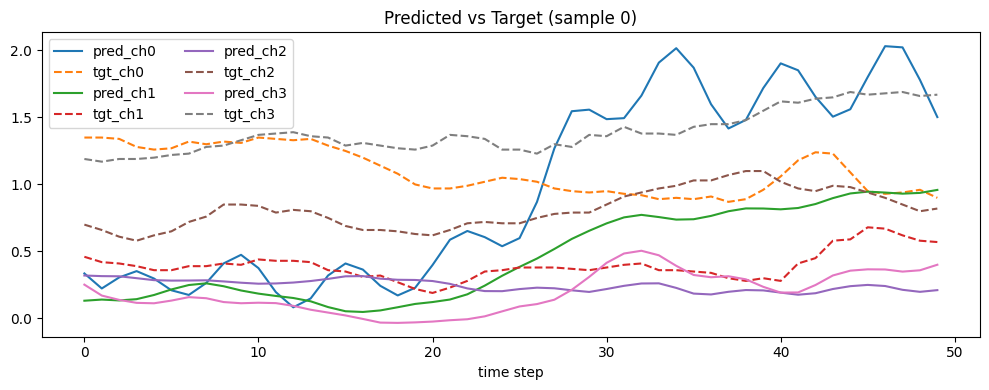

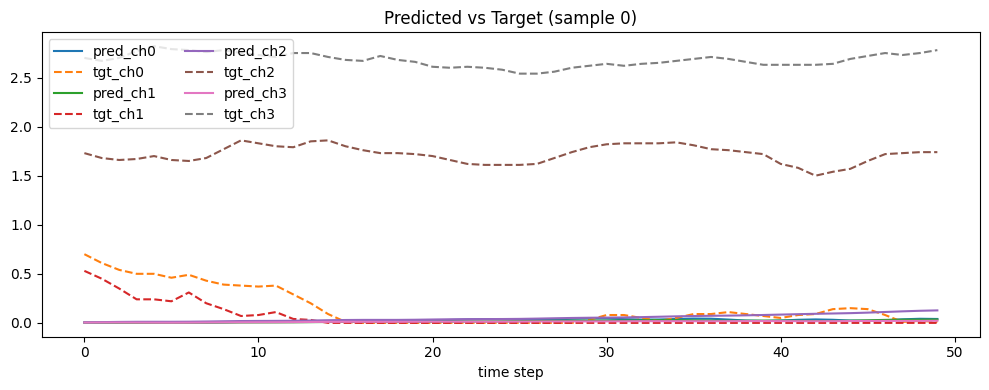

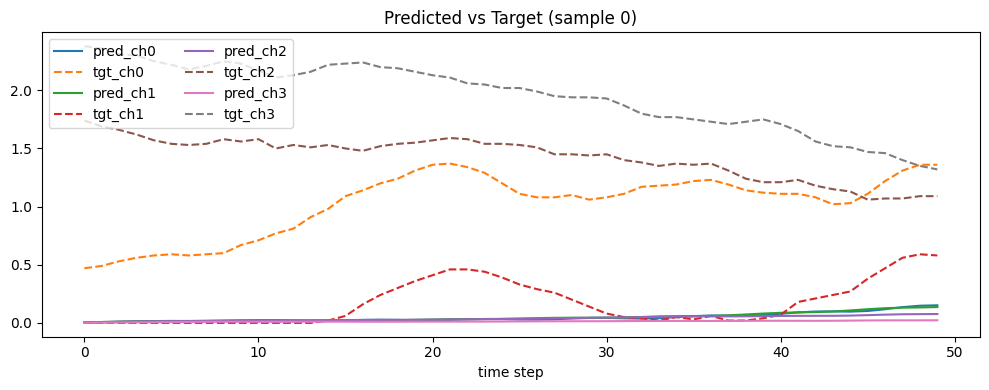

In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt

ckpt_path = "/net/tscratch/people/plgfimpro/korelacje/models_with_revin/masked_m1_in100_out50_lr1e-3-2.pt"
ckpt = torch.load(ckpt_path, map_location=device)
state = ckpt.get("model_state_dict", ckpt)
model.load_state_dict(state)
model.to(device)
print(f"Loaded model from {ckpt_path}")
model.eval()
idx = 0
with torch.no_grad():
    for val_src, val_tgt, val_len_x, val_len_y, val_src_pad_mask, val_tgt_pad_mask in tqdm(test_loader, desc=f'val epoch {epoch}', leave=False):
        vs = val_src.to(device)
        vt = val_tgt.to(device)
        src_mask = val_src_pad_mask.to(device)
        tgt_mask = val_tgt_pad_mask.to(device)
        child_src = vs[..., :2]
        mom_src = vs[..., 2:]
        child_tgt_in = val_tgt_in[..., :2].to(device)
        mom_tgt_in = val_tgt_in[..., 2:].to(device)
        pred = model(
            child_src,
            mom_src,
            child_tgt_in,
            mom_tgt_in,
            mask_child=False,
            mask_mom=False,
            src_key_padding_mask=src_mask,
            tgt_key_padding_mask=tgt_mask,
        )

        pred_np = pred.cpu().numpy()
        tgt_np = vt.cpu().numpy()

        sample_idx = 0
        T = pred_np.shape[1]
        time = np.arange(T)

        plt.figure(figsize=(10, 4))
        for ch in range(pred_np.shape[2]):
            plt.plot(time, pred_np[sample_idx, :, ch], label=f'pred_ch{ch}')
            plt.plot(time, tgt_np[sample_idx, :, ch], '--', label=f'tgt_ch{ch}')
        plt.xlabel('time step')
        plt.legend(loc='upper left', ncol=2)
        plt.title('Predicted vs Target (sample 0)')
        plt.tight_layout()
        plt.show()
        idx= idx + 1
        if idx >= 3:
            break